In [1]:
%load_ext autoreload
%autoreload 2

# Clasificación de minas por medio de A-Scans (MPDL-LR) usando datos GPRMax


## Importación de librerias

In [2]:
import logging
import joblib
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from utils import get_output_data, read_c_scan, plot_mine_map
from dictionary_learning import MPDLLRClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [3]:
logging.basicConfig(level=logging.DEBUG, force=True)
log = logging.getLogger(__name__)

## Carga de Escenarios

### Escenario 1 - Clutter

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\leone\\anaconda3\\envs\\Demining\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\leone\\anaconda3\\envs\\Demining\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\leone\\anaconda3\\envs\

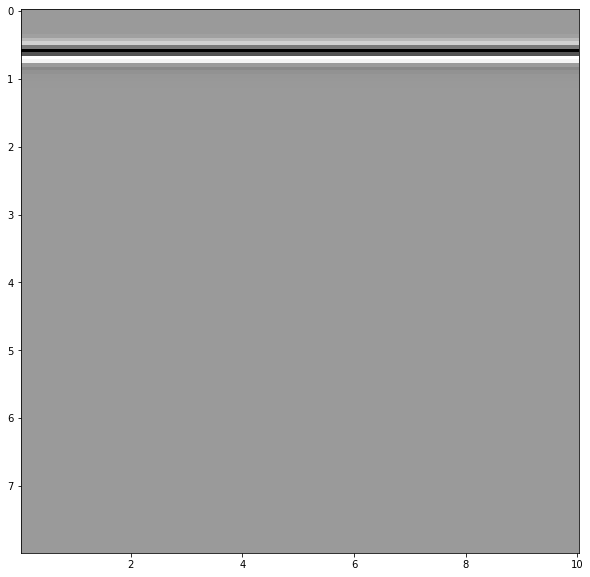

In [4]:
b_scan, d_t = get_output_data("../data/mpdl_lr_clutter_merged.out", 1 , "Ez")
b_scan = b_scan.swapaxes(0, 1)
q_x, q_t = b_scan.shape
d_x = 0.05
x = np.linspace(d_x, q_x*d_x, q_x, endpoint=True)
t = np.linspace(0, q_t*d_t, q_t, endpoint=True)

b_scan ,t = signal.resample(b_scan, 150, t, axis=1)
#noise = np.random.normal(0, np.std(b_scan)/1000, b_scan.shape)
#b_scan = b_scan + noise

X_0 = b_scan

q_x, q_t = b_scan.shape

fig, (ax) = plt.subplots(1, 1, figsize = (10, 10))
ax.pcolor(x, t*1e9, b_scan.swapaxes(0, 1), cmap='gist_gray')
#ax.plot(np.repeat(x[np.abs(x-4.1) < 0.035], t.size), t*1e9, "r")
ax.invert_yaxis()

### Escenario 1

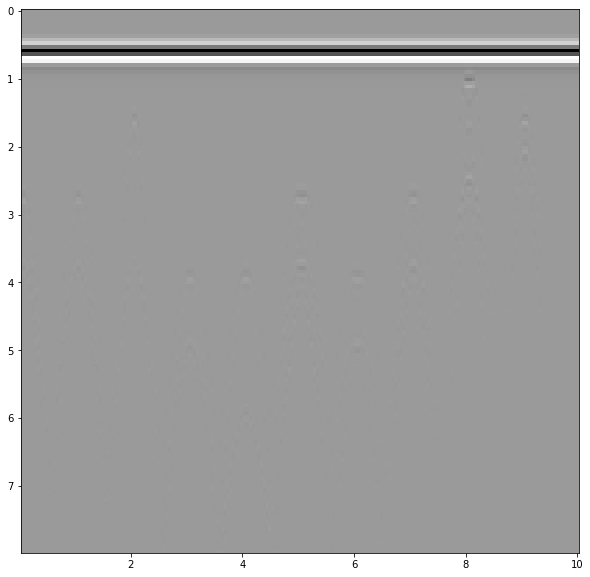

In [5]:
b_scan, d_t = get_output_data("../data/mpdl_lr_merged.out", 1 , "Ez")
b_scan = b_scan.swapaxes(0, 1)
q_x, q_t = b_scan.shape
d_x = 0.05
x = np.linspace(d_x, q_x*d_x, q_x, endpoint=True)
t = np.linspace(0, q_t*d_t, q_t, endpoint=True)

b_scan ,t = signal.resample(b_scan, 150, t, axis=1)
#noise = np.random.normal(0, np.std(b_scan)/10000, b_scan.shape)
#b_scan = b_scan + noise

q_x, q_t = b_scan.shape

mine_map = np.zeros(x.size)
mine_map[np.abs(x-0.1) < 0.035] = 1
mine_map[np.abs(x-1.1) < 0.040] = 1
mine_map[np.abs(x-2.1) < 0.035] = 1
mine_map[np.abs(x-3.1) < 0.050] = 1
mine_map[np.abs(x-4.1) < 0.050] = 1
mine_map[np.abs(x-5.1) < 0.100] = 1
mine_map[np.abs(x-6.1) < 0.100] = 1
mine_map[np.abs(x-7.1) < 0.070] = 1
mine_map[np.abs(x-8.1) < 0.080] = 1
mine_map[np.abs(x-9.1) < 0.050] = 1

y_1 = mine_map
X_1 = b_scan

fig, (ax) = plt.subplots(1, 1, figsize = (10, 10))
ax.pcolor(x, t*1e9, b_scan.swapaxes(0, 1), cmap='gist_gray')
#ax.plot(np.repeat(x[np.abs(x-4.1) < 0.035], t.size), t*1e9, "r")
ax.invert_yaxis()

### Escenario 2

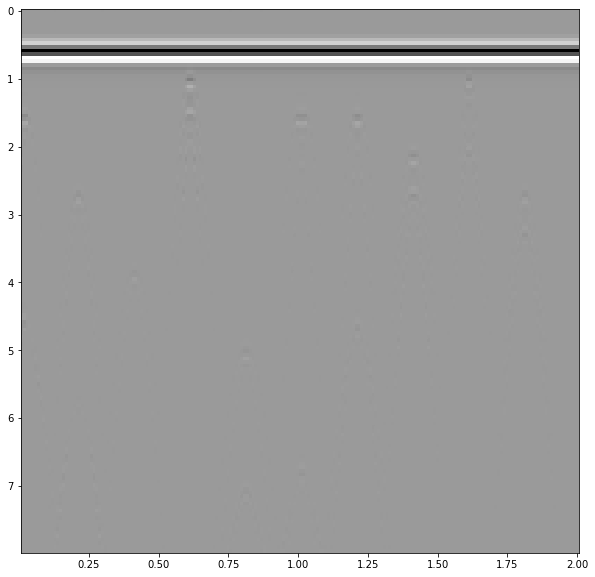

In [6]:
b_scan, d_t = get_output_data("../data/mpdl_lr_v2_merged.out", 1 , "Ez")
b_scan = b_scan.swapaxes(0, 1)
q_x, q_t = b_scan.shape
d_x = 0.01
x = np.linspace(d_x, q_x*d_x, q_x, endpoint=True)
t = np.linspace(0, q_t*d_t, q_t, endpoint=True)

b_scan ,t = signal.resample(b_scan, 150, t, axis=1)
#noise = np.random.normal(0, np.std(b_scan)/10000, b_scan.shape)
#b_scan = b_scan + noise

q_x, q_t = b_scan.shape

mine_map = np.zeros(x.size)
mine_map[np.abs(x-0.1) < 0.035] = 1
mine_map[np.abs(x-1.1) < 0.040] = 1
mine_map[np.abs(x-2.1) < 0.035] = 1
mine_map[np.abs(x-3.1) < 0.050] = 1
mine_map[np.abs(x-4.1) < 0.050] = 1
mine_map[np.abs(x-5.1) < 0.100] = 1
mine_map[np.abs(x-6.1) < 0.100] = 1
mine_map[np.abs(x-7.1) < 0.070] = 1
mine_map[np.abs(x-8.1) < 0.080] = 1
mine_map[np.abs(x-9.1) < 0.050] = 1

y_2 = mine_map
X_2 = b_scan

fig, (ax) = plt.subplots(1, 1, figsize = (10, 10))
ax.pcolor(x, t*1e9, b_scan.swapaxes(0, 1), cmap='gist_gray')
#ax.plot(np.repeat(x[np.abs(x-4.1) < 0.035], t.size), t*1e9, "r")
ax.invert_yaxis()

### Escenario 3

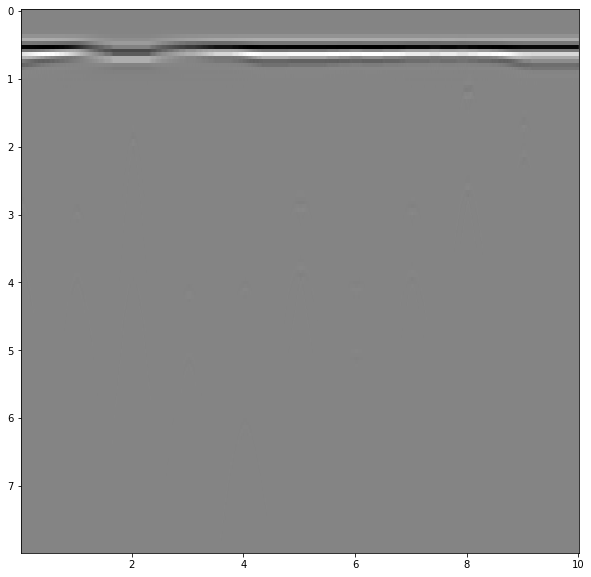

In [7]:
b_scan, d_t = get_output_data("../data/mpdl_lr_v3_merged.out", 1 , "Ez")
b_scan = b_scan.swapaxes(0, 1)
q_x, q_t = b_scan.shape
d_x = 0.01
x = np.linspace(d_x, q_x*d_x, q_x, endpoint=True)
t = np.linspace(0, q_t*d_t, q_t, endpoint=True)

b_scan ,t = signal.resample(b_scan, 150, t, axis=1)
#noise = np.random.normal(0, np.std(b_scan)/10000, b_scan.shape)
#b_scan = b_scan + noise

q_x, q_t = b_scan.shape

mine_map = np.zeros(x.size)
mine_map[np.abs(x-0.1) < 0.035] = 1
mine_map[np.abs(x-1.1) < 0.040] = 1
mine_map[np.abs(x-2.1) < 0.035] = 1
mine_map[np.abs(x-3.1) < 0.050] = 1
mine_map[np.abs(x-4.1) < 0.050] = 1
mine_map[np.abs(x-5.1) < 0.100] = 1
mine_map[np.abs(x-6.1) < 0.100] = 1
mine_map[np.abs(x-7.1) < 0.070] = 1
mine_map[np.abs(x-8.1) < 0.080] = 1
mine_map[np.abs(x-9.1) < 0.050] = 1

y_3 = mine_map
X_3 = b_scan

fig, (ax) = plt.subplots(1, 1, figsize = (10, 10))
ax.pcolor(x, t*1e9, b_scan.swapaxes(0, 1), cmap='gist_gray')
#ax.plot(np.repeat(x[np.abs(x-4.1) < 0.035], t.size), t*1e9, "r")
ax.invert_yaxis()

### Escenario 4 - Clutter

Text(0, 0.5, 't (ns)')

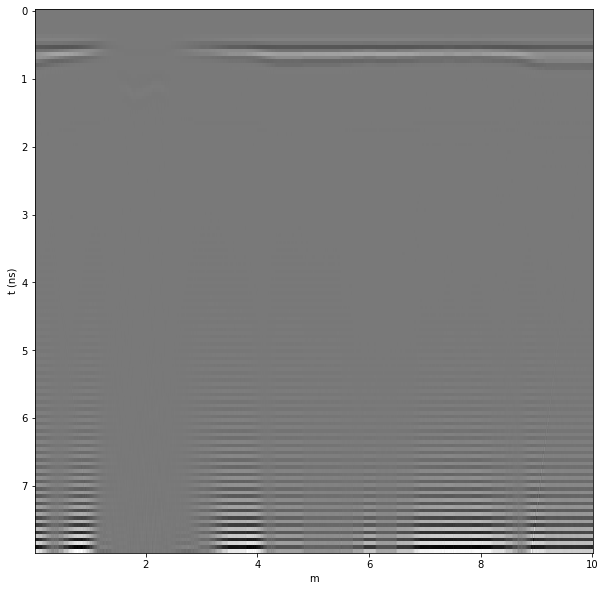

In [8]:
b_scan, d_t = get_output_data("../data/mpdl_lr_v4_clutter_merged.out", 1 , "Ez")
b_scan = b_scan.swapaxes(0, 1)
q_x, q_t = b_scan.shape
d_x = 0.01
x = np.linspace(d_x, q_x*d_x, q_x, endpoint=True)
t = np.linspace(0, q_t*d_t, q_t, endpoint=True)

b_scan ,t = signal.resample(b_scan, 150, t, axis=1)
#noise = np.random.normal(0, np.std(b_scan)/10000, b_scan.shape)
#b_scan = b_scan + noise

q_x, q_t = b_scan.shape

mine_map = np.zeros(x.size)

y_4_c = mine_map
X_4_c = b_scan

fig, (ax) = plt.subplots(1, 1, figsize = (10, 10))
ax.pcolor(x, t*1e9, b_scan.swapaxes(0, 1)*np.exp(1e9*t)[:, np.newaxis], cmap='gist_gray')
#ax.plot(np.repeat(x[np.abs(x-4.1) < 0.035], t.size), t*1e9, "r")
ax.invert_yaxis()
ax.set_xlabel("m")
ax.set_ylabel("t (ns)")

### Escenario 4

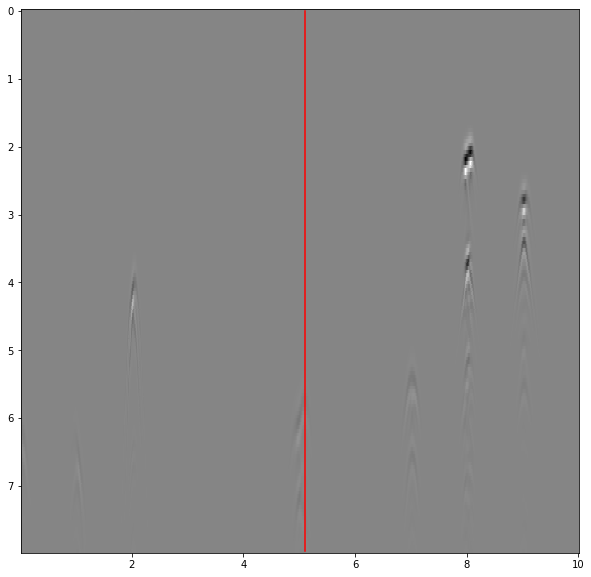

In [9]:
b_scan, d_t = get_output_data("../data/mpdl_lr_v4_merged.out", 1 , "Ez")
b_scan = b_scan.swapaxes(0, 1)
q_x, q_t = b_scan.shape
d_x = 0.01
x = np.linspace(d_x, q_x*d_x, q_x, endpoint=True)
t = np.linspace(0, q_t*d_t, q_t, endpoint=True)

b_scan ,t = signal.resample(b_scan, 150, t, axis=1)
#noise = np.random.normal(0, np.std(b_scan)/10000, b_scan.shape)
#b_scan = b_scan + noise

q_x, q_t = b_scan.shape

mine_map = np.zeros(x.size)
mine_map[np.abs(x-0.1) < 0.035] = 1
mine_map[np.abs(x-1.1) < 0.040] = 1
mine_map[np.abs(x-2.1) < 0.035] = 1
mine_map[np.abs(x-3.1) < 0.050] = 1
mine_map[np.abs(x-4.1) < 0.050] = 1
mine_map[np.abs(x-5.1) < 0.100] = 1
mine_map[np.abs(x-6.1) < 0.100] = 1
mine_map[np.abs(x-7.1) < 0.070] = 1
mine_map[np.abs(x-8.1) < 0.080] = 1
mine_map[np.abs(x-9.1) < 0.050] = 1

y_4 = mine_map
X_4 = b_scan

fig, (ax) = plt.subplots(1, 1, figsize = (10, 10))
ax.pcolor(x, t*1e9, b_scan.swapaxes(0, 1)-X_4_c.swapaxes(0, 1) , cmap='gist_gray')
ax.plot(np.repeat(5.1, t.size), t*1e9, "r")
ax.invert_yaxis()

Text(0, 0.5, 't (ns)')

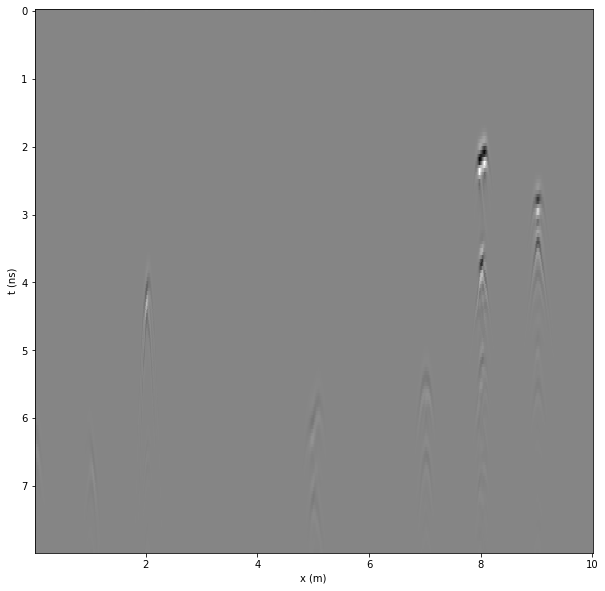

In [10]:
fig, (ax) = plt.subplots(1, 1, figsize = (10, 10))
ax.pcolor(x, t*1e9, X_4.swapaxes(0, 1) - X_4_c.swapaxes(0, 1), cmap='gist_gray')
#ax.plot(np.repeat(x[np.abs(x-4.1) < 0.035], t.size), t*1e9, "r")
ax.invert_yaxis()
ax.set_xlabel("x (m)")
ax.set_ylabel("t (ns)")

In [16]:
X_4_t = X_4 - X_4_c
idx, _ = np.nonzero(X_4_t > X_4_t.mean()+1*X_4_t.std())
idx = np.unique(idx)
idx.size

154

In [17]:
y_4 = np.zeros(x.size)
y_4_th = np.zeros(y_4.size)
y_4_th[idx] = 1
y_4[(mine_map==1) & (y_4_th ==1)] = 1

In [18]:
np.count_nonzero(y_4==1)

72

In [ ]:
X_5_c = np.
X_5_t = X_4 - X_4_c
idx, _ = np.nonzero(X_4_t > X_4_t.mean()+1*X_4_t.std())
idx = np.unique(idx)
idx.size

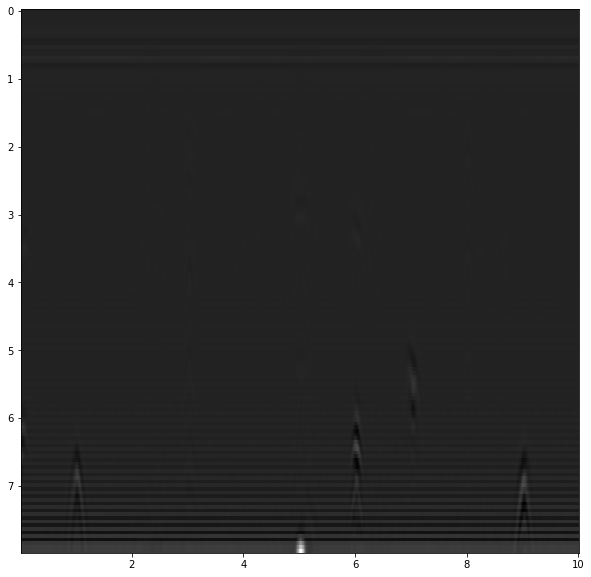

In [15]:
from scipy import ndimage

b_scan, d_t = get_output_data("../data/mpdl_lr_v5_merged.out", 1 , "Ez")
b_scan = b_scan.swapaxes(0, 1)
q_x, q_t = b_scan.shape
d_x = 0.01
x = np.linspace(d_x, q_x*d_x, q_x, endpoint=True)
t = np.linspace(0, q_t*d_t, q_t, endpoint=True)

b_scan ,t = signal.resample(b_scan, 150, t, axis=1)
#noise = np.random.normal(0, np.std(b_scan)/10000, b_scan.shape)
#b_scan = b_scan + noise
mov_avg = ndimage.uniform_filter(b_scan, size=(5, 5))


q_x, q_t = b_scan.shape

y_5 = mine_map
X_5 = b_scan

fig, (ax) = plt.subplots(1, 1, figsize = (10, 10))
ax.pcolor(x, t*1e9, mov_avg.swapaxes(0, 1)*np.exp(1e9*t)[:, np.newaxis], cmap='gist_gray')
#ax.plot(np.repeat(x[np.abs(x-4.1) < 0.035], t.size), t*1e9, "r")
ax.invert_yaxis()

In [28]:
mov_avg.shape

(1000, 150)

### Concatenación de Escenarios

In [20]:
X = np.column_stack((X_4*np.exp(1e9*t)[np.newaxis,:], X_4_c*np.exp(1e9*t)[np.newaxis,:]))
#X = np.row_stack((X, np.column_stack((X_3, X_1))))

y = y_4
#y = np.concatenate((y_2,))
#y_train[y_train ==2] = 1

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=4)

rus = RandomUnderSampler(random_state=4)
#ros = RandomOverSampler(random_state=27)
X_res, y_res = rus.fit_resample(X_train, y_train)
#X_res, y_res = X_train, y_train
#X_res, y_res = ros.fit_resample(X_res, y_res)
# #from scipy.ndimage.interpolation import shift
X_res_forward = np.roll(X_res, 1, axis=1)
X_res_backward = np.roll(X_res, -1, axis=1)

X_res = np.row_stack((X_res,X_res_forward, X_res_backward ))
y_res = np.concatenate((y_res, y_res, y_res))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates

C:\Users\leone\anaconda3\envs\Demining\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\leone\anaconda3\envs\Demining\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\leone\OneDrive - Universidad de los Andes\Universidad\Proyecto Desminado\GPR\dictionary_learning\mpdl_lr.py", line 232, in fit
    D_i = Omega @ linalg.inv(
  File "C:\Users\leone\anaconda3\envs\Demining\lib\site-packages\scipy\linalg\_basic.py", line 968, in inv
    r

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates

C:\Users\leone\anaconda3\envs\Demining\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\leone\anaconda3\envs\Demining\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\leone\anaconda3\envs\Demining\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\leone\anaconda3\envs\Demining\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\leone\anaconda3\envs\Demining\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates

C:\Users\leone\anaconda3\envs\Demining\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\leone\anaconda3\envs\Demining\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\leone\anaconda3\envs\Demining\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits


DEBUG:dictionary_learning.mpdl_lr:H before if: [0]
DEBUG:dictionary_learning.mpdl_lr:Entered in H if
DEBUG:dictionary_learning.mpdl_lr:H after if: [1 0]
DEBUG:dictionary_learning.mpdl_lr:H after swap: [1 0]
DEBUG:dictionary_learning.mpdl_lr:H calculated from y with shape: (2, 348)
DEBUG:dictionary_learning.mpdl_lr:W initialized with shape: (2, 48)
DEBUG:dictionary_learning.mpdl_lr:B initialized with shape: (2, 348)
DEBUG:dictionary_learning.mpdl_lr:A_1 initialized with shape: (48, 150)
DEBUG:dictionary_learning.mpdl_lr:A_2 initialized with shape: (150, 150)
DEBUG:dictionary_learning.mpdl_lr:SDV for P took: 0.018483600004401524 s
DEBUG:dictionary_learning.mpdl_lr:P initialized with shape: ()
DEBUG:dictionary_learning.mpdl_lr:D list initialized
DEBUG:dictionary_learning.mpdl_lr:S list initialized
DEBUG:dictionary_learning.mpdl_lr:Phi list initialized
DEBUG:dictionary_learning.mpdl_lr:Y calculated from D and S  with shape: (150, 348)
DEBUG:dictionary_learning.mpdl_lr:Y hat calculated from

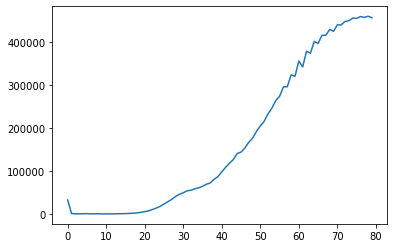

In [30]:
opt = BayesSearchCV(
    MPDLLRClassifier(
        transfer_function="soft_plus",
        X_c = "split",
        normalize = True,
        max_iter=80),
    {
        'lmd': Real(1e-6, 1e+6, prior='uniform'),
        'beta': Real(1e-6, 1e+6, prior='uniform'),
        'alpha_1': Real(1e-6, 1e+6, prior='uniform'),
        'alpha_2': Real(1e-6, 1e+6, prior='uniform'),
        'alpha_3': Real(1e-6, 1e+6, prior='uniform'),
        'tau': Real(1e-6, 1e+6, prior='uniform'),
        'a_1': Integer(2, 75),
        'a_2': Integer(75, 150),
    },
    scoring='f1_macro',
    n_iter=500,
    random_state=0,
    n_jobs=3,
    n_points=3,
    error_score=0,
    verbose=2
)

opt.fit(X_res, y_res)
cls = opt.best_estimator_

In [31]:
opt.best_score_

0.8095626982202546

In [35]:
opt.best_params_

OrderedDict([('a_1', 24),
             ('a_2', 150),
             ('alpha_1', 180044.90449373715),
             ('alpha_2', 105857.29243298693),
             ('alpha_3', 1e-06),
             ('beta', 1000000.0),
             ('lmd', 1e-06),
             ('tau', 1e-06)])

DEBUG:dictionary_learning.mpdl_lr:H before if: [0]
DEBUG:dictionary_learning.mpdl_lr:Entered in H if
DEBUG:dictionary_learning.mpdl_lr:H after if: [1 0]
DEBUG:dictionary_learning.mpdl_lr:H after swap: [1 0]
DEBUG:dictionary_learning.mpdl_lr:H calculated from y with shape: (2, 348)
DEBUG:dictionary_learning.mpdl_lr:W initialized with shape: (2, 24)
DEBUG:dictionary_learning.mpdl_lr:B initialized with shape: (2, 348)
DEBUG:dictionary_learning.mpdl_lr:A_1 initialized with shape: (24, 150)
DEBUG:dictionary_learning.mpdl_lr:A_2 initialized with shape: (150, 150)
DEBUG:dictionary_learning.mpdl_lr:SDV for P took: 0.03832759999932023 s
DEBUG:dictionary_learning.mpdl_lr:P initialized with shape: ()
DEBUG:dictionary_learning.mpdl_lr:D list initialized
DEBUG:dictionary_learning.mpdl_lr:S list initialized
DEBUG:dictionary_learning.mpdl_lr:Phi list initialized
DEBUG:dictionary_learning.mpdl_lr:Y calculated from D and S  with shape: (150, 348)
DEBUG:dictionary_learning.mpdl_lr:Y hat calculated from 

MPDLLRClassifier(X_c='split', a_1=24, a_2=150, alpha_1=180044.90449373715,
                 alpha_2=105857.29243298693, alpha_3=1e-06, beta=1000000.0,
                 lmd=1e-06, tau=1e-06,
                 transfer_function=<function soft_plus at 0x00000253236D9C10>)

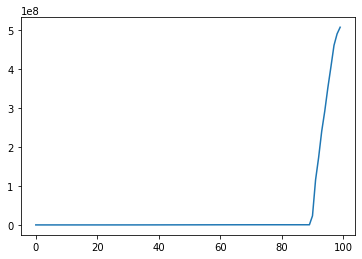

In [39]:
cls = MPDLLRClassifier(
        a_1 = 24,
        a_2 = 150,
        alpha_1 =180044.90449373715,
        alpha_2 = 105857.29243298693,
        alpha_3 = 1e-06,
        beta = 1000000.0,
        lmd = 1e-06,
        tau= 1e-06,
        transfer_function="soft_plus",
        X_c = "split",
        normalize = True,
        max_iter=100)

cls.fit(X_res, y_res)

In [53]:
joblib.dump(cls, '../output/mpdl_lr_gprMax.sav')

['../output/mpdl_lr_gprMax.sav']

In [15]:
cls = joblib.load('../output/mpdl_lr_gprMax.sav')

C:\Users\leone\OneDrive - Universidad de los Andes\Universidad\Proyecto Desminado\GPR\dictionary_learning\mpdl_lr.py:42: RuntimeWarning: overflow encountered in exp
  (1 / beta) * np.log(1 + np.exp(beta * x)))


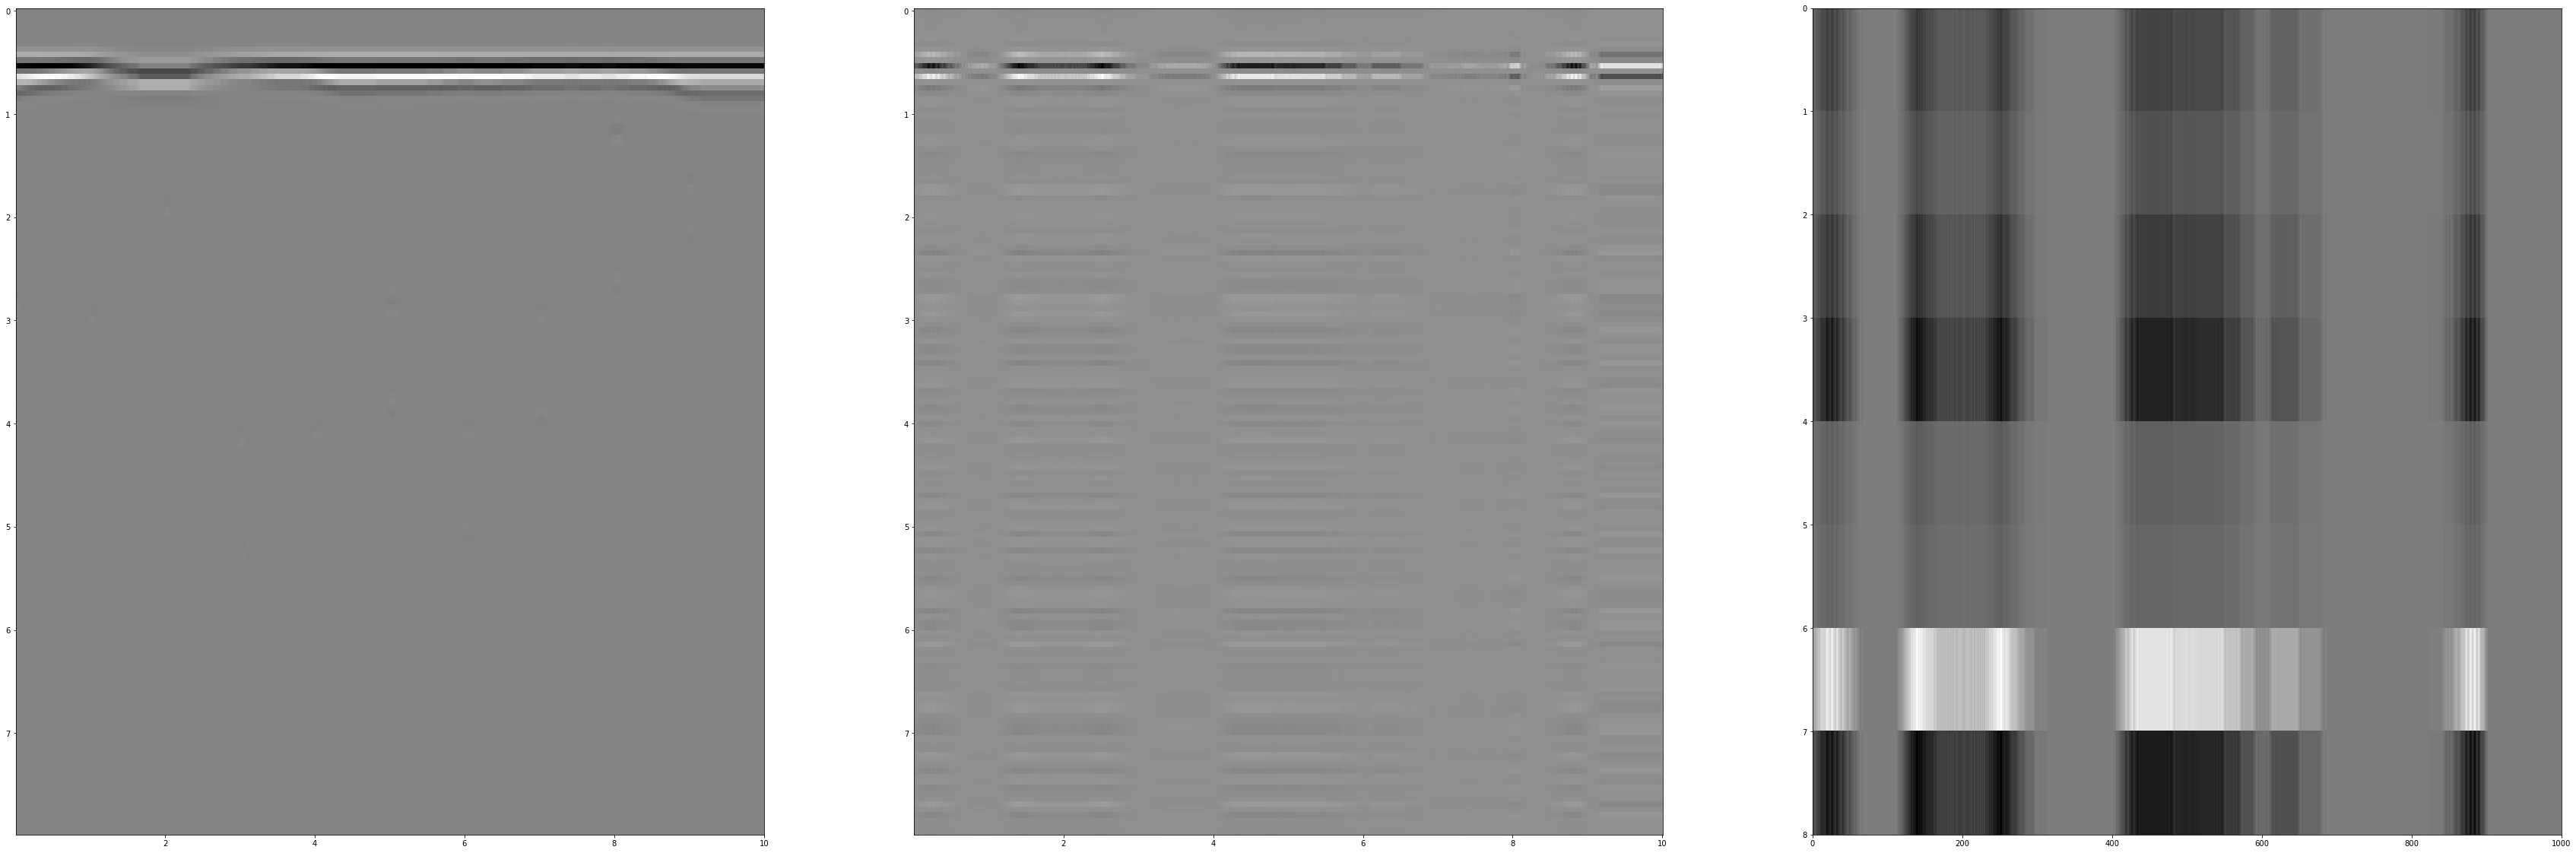

In [16]:
b_scan_t = opt.best_estimator_.named_steps.MPDLLR.remove_clutter(b_scan[:]*np.exp(1e9*t)[np.newaxis,:])
sp_t = opt.best_estimator_.named_steps.MPDLLR.get_coding(b_scan[:])
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (60, 20))
ax1.pcolor(x[:], t[:]/10**-9, b_scan[:, :].swapaxes(0, 1), cmap='gist_gray')
ax1.invert_yaxis()

ax2.pcolor(x[:], t[:]/10**-9, b_scan_t[:, :].swapaxes(0, 1), cmap='gist_gray')
ax2.invert_yaxis()

ax3.pcolor(sp_t.swapaxes(0, 1), cmap='gist_gray')
ax3.invert_yaxis()

In [19]:
b_scan, d_t = get_output_data("../data/mpdl_lr_test_merged.out", 1 , "Ez")
b_scan = b_scan.swapaxes(0, 1)
q_x, q_t = b_scan.shape
d_x = 0.05
x = np.linspace(0.05, q_x*d_x, q_x, endpoint=True)
t = np.linspace(0, q_t*d_t, q_t, endpoint=True)

b_scan_test ,t = signal.resample(b_scan, 150, t, axis=1)


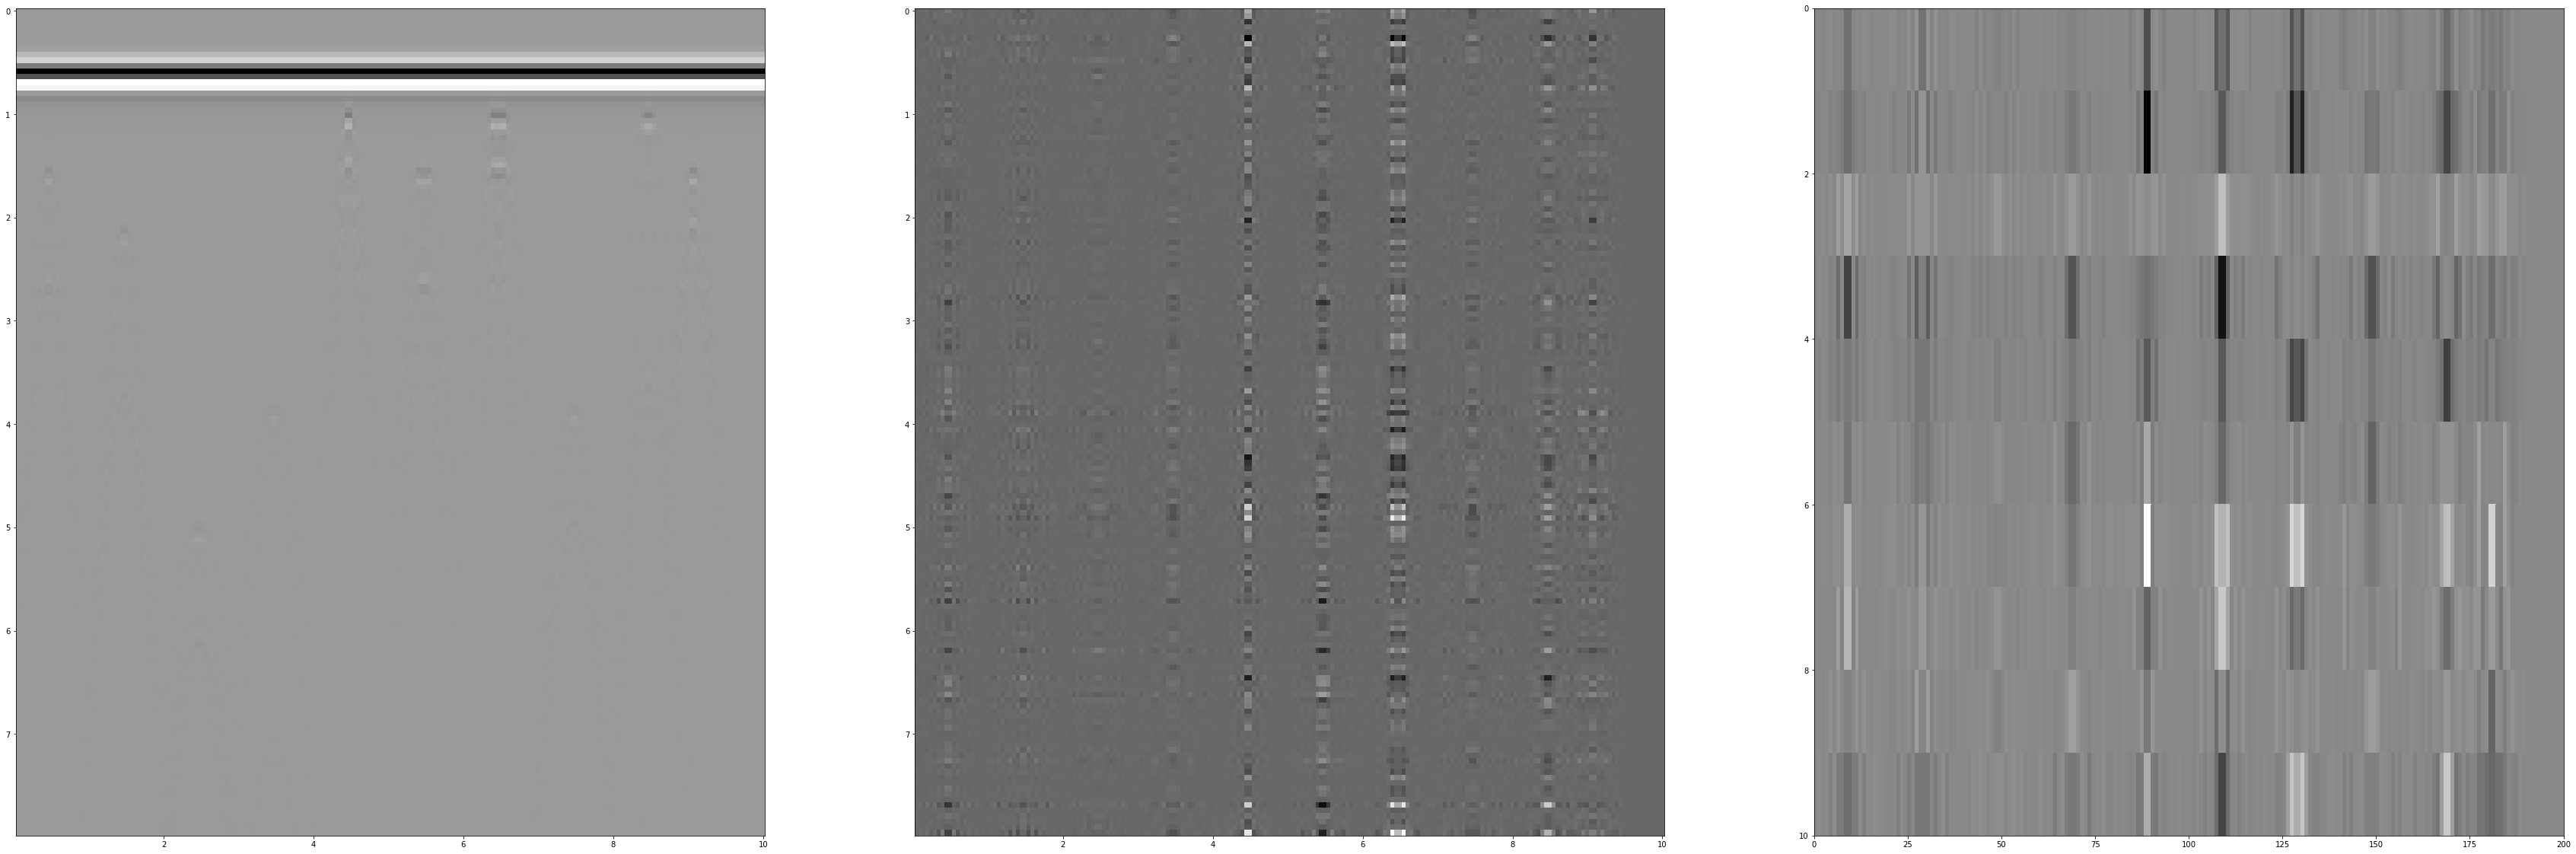

In [17]:
b_scan_t = opt.best_estimator_.named_steps.MPDLLR.remove_clutter(b_scan_test[:])
sp_t = opt.best_estimator_.named_steps.MPDLLR.get_coding(b_scan_test[:])
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (60, 20))
ax1.pcolor(x[:], t[:]/10**-9, b_scan_test[:, :].swapaxes(0, 1), cmap='gist_gray')
ax1.invert_yaxis()

ax2.pcolor(x[:], t[:]/10**-9, b_scan_t[:, :].swapaxes(0, 1), cmap='gist_gray')
ax2.invert_yaxis()

ax3.pcolor(sp_t.swapaxes(0, 1), cmap='gist_gray')
ax3.invert_yaxis()

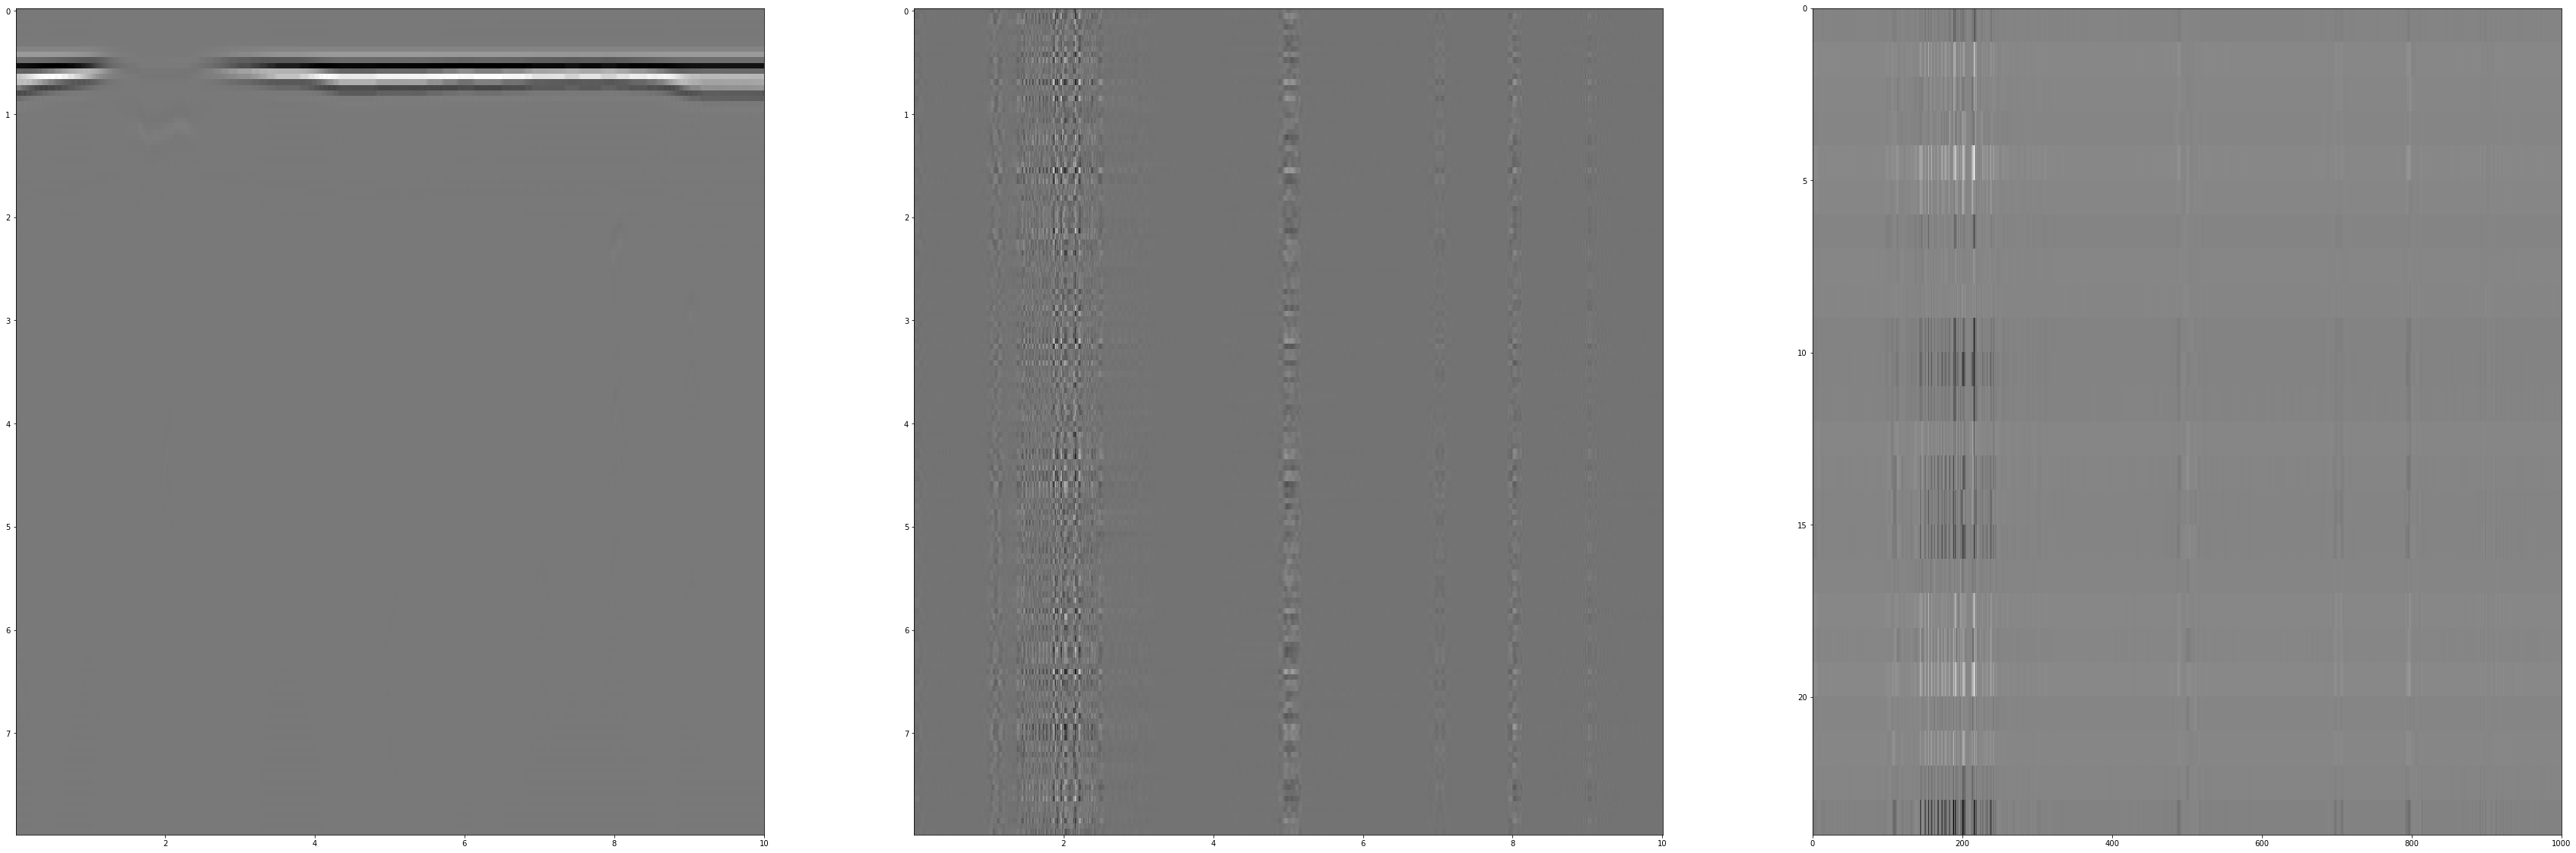

In [36]:
b_scan_t = cls.remove_clutter(X_4*np.exp(1e9*t)[np.newaxis,:])
sp_t = cls.get_coding(X_4*np.exp(1e9*t)[np.newaxis,:])
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (60, 20))
ax1.pcolor(x[:], t[:]/10**-9, X_4.swapaxes(0, 1), cmap='gist_gray')
ax1.invert_yaxis()

ax2.pcolor(x[:], t[:]/10**-9, b_scan_t.swapaxes(0, 1), cmap='gist_gray')
ax2.invert_yaxis()

ax3.pcolor(sp_t.swapaxes(0, 1), cmap='gist_gray')
ax3.invert_yaxis()

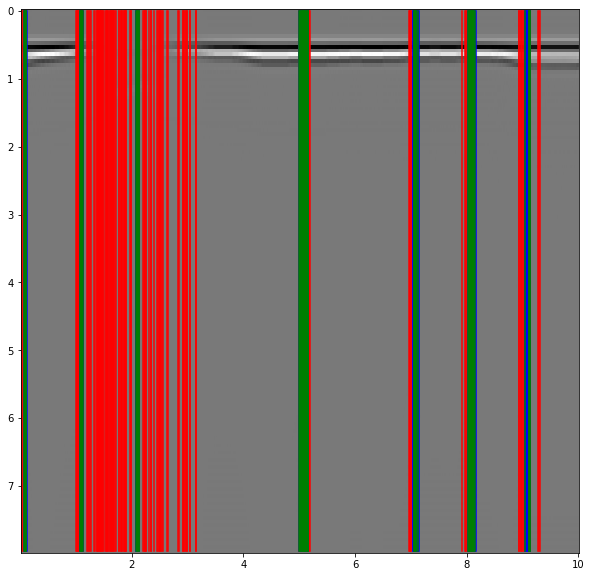

In [50]:
y_pred = cls.predict(X_4*np.exp(1e9*t)[np.newaxis,:])
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.pcolor(x[:], t[:]/10**-9, X_4.swapaxes(0, 1), cmap='gist_gray')
ax.invert_yaxis()
for idx in np.nonzero(y_pred ==True)[0]:
    ax.plot(np.repeat(x[idx], t.size), t*1e9, "r")
for idx in np.nonzero(y_4 ==True)[0]:
    ax.plot(np.repeat(x[idx], t.size), t*1e9, "b")
for idx in np.nonzero((y_4 ==True) & (y_pred ==True) )[0]:
    ax.plot(np.repeat(x[idx], t.size), t*1e9, "g")

In [19]:
y_pred = cls.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.85      0.91       186
         1.0       0.24      0.64      0.35        14

    accuracy                           0.83       200
   macro avg       0.61      0.75      0.63       200
weighted avg       0.92      0.83      0.87       200



In [16]:
y_pred = cls.predict(X_4*np.exp(1e9*t)[np.newaxis,:])
print(classification_report(y_4, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92       928
         1.0       0.33      0.81      0.47        72

    accuracy                           0.87      1000
   macro avg       0.66      0.84      0.70      1000
weighted avg       0.94      0.87      0.89      1000



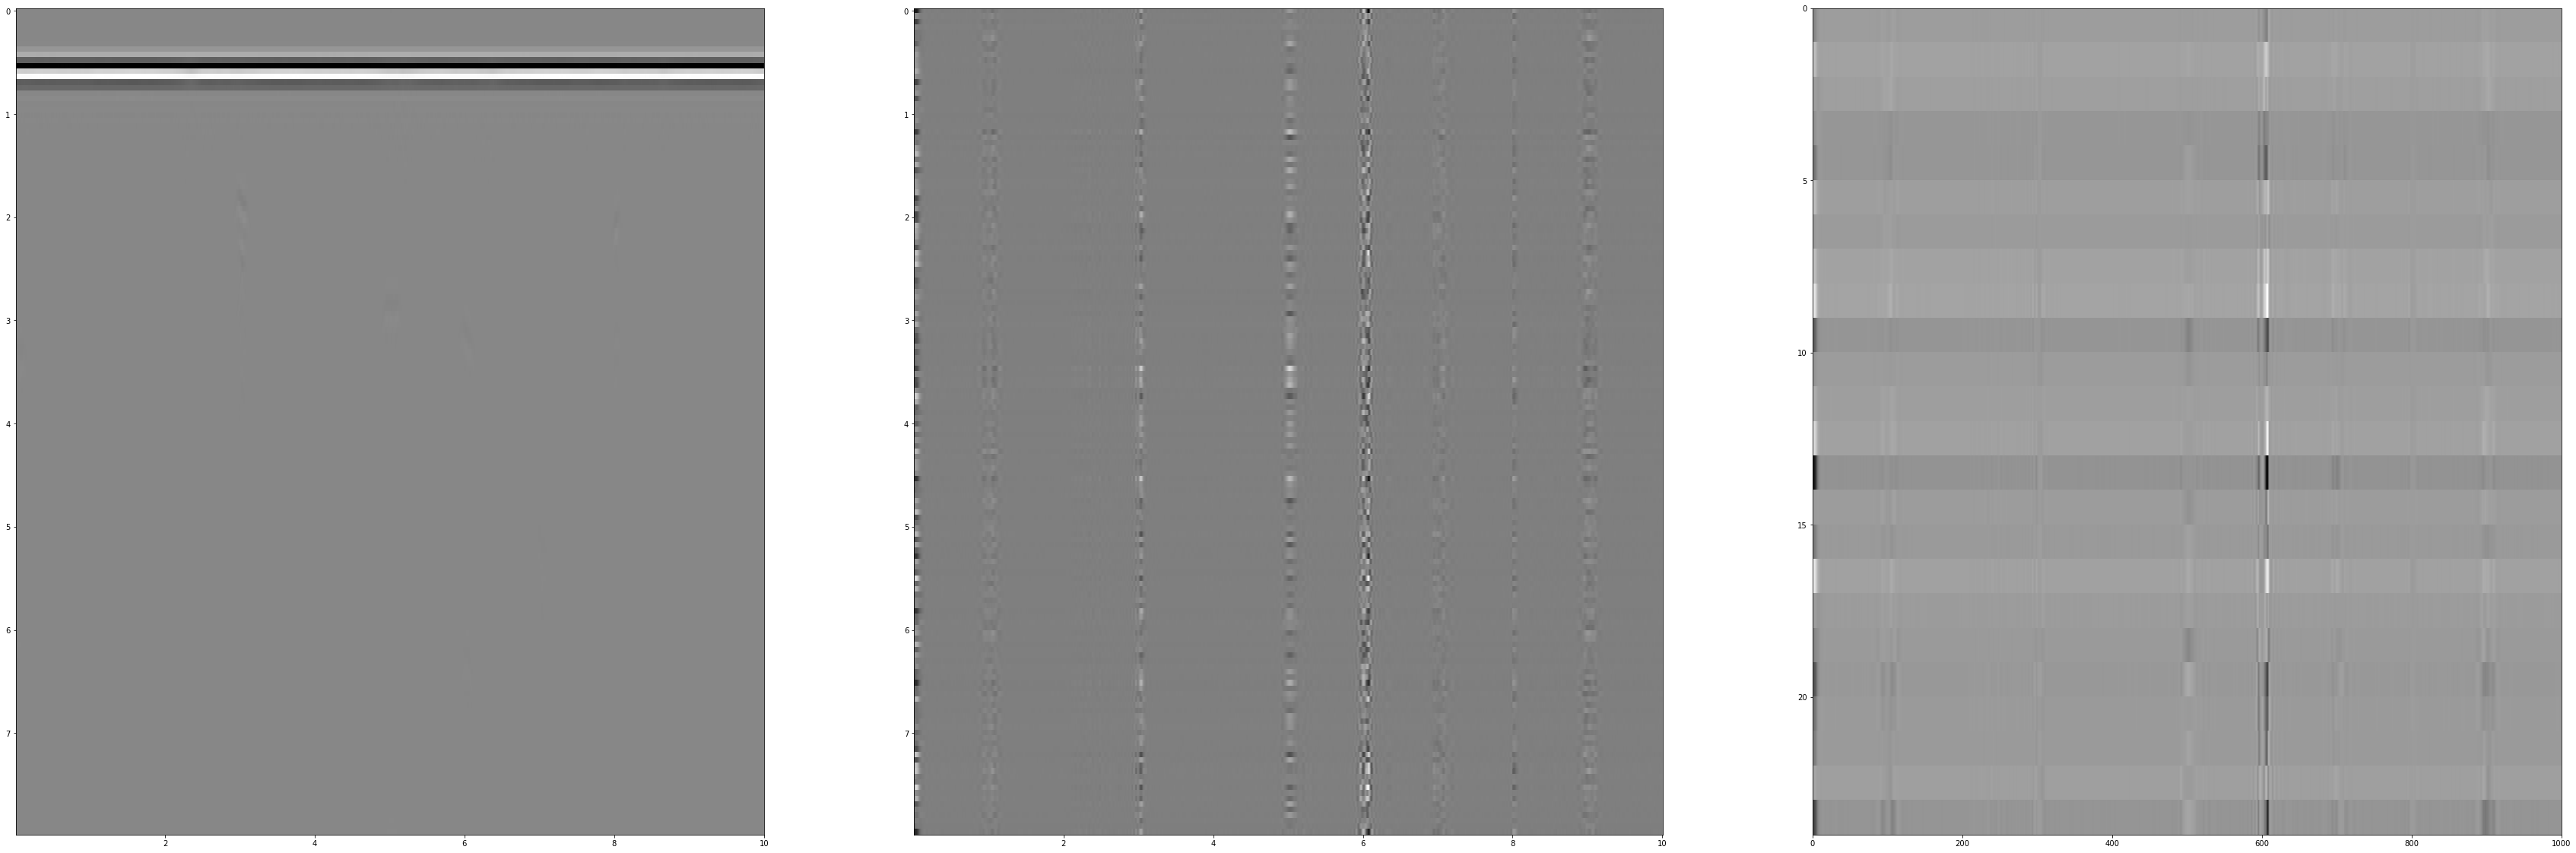

In [32]:
b_scan_t = cls.remove_clutter(X_5*np.exp(1e9*t)[np.newaxis,:])
sp_t = cls.get_coding(X_5*np.exp(1e9*t)[np.newaxis,:])
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (60, 20))
ax1.pcolor(x[:], t[:]/10**-9, X_5.swapaxes(0, 1), cmap='gist_gray')
ax1.invert_yaxis()

ax2.pcolor(x[:], t[:]/10**-9, b_scan_t.swapaxes(0, 1), cmap='gist_gray')
ax2.invert_yaxis()

ax3.pcolor(sp_t.swapaxes(0, 1), cmap='gist_gray')
ax3.invert_yaxis()

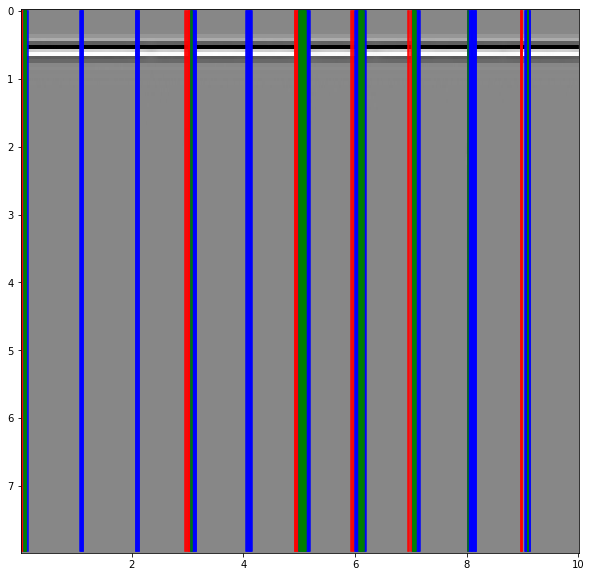

In [24]:
y_pred = cls.predict(X_5*np.exp(1e9*t)[np.newaxis,:])
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.pcolor(x[:], t[:]/10**-9, X_5.swapaxes(0, 1), cmap='gist_gray')
ax.invert_yaxis()
for idx in np.nonzero(y_pred ==True)[0]:
    ax.plot(np.repeat(x[idx], t.size), t*1e9, "r")
for idx in np.nonzero(y_5 ==True)[0]:
    ax.plot(np.repeat(x[idx], t.size), t*1e9, "b")
for idx in np.nonzero((y_5 ==True) & (y_pred ==True) )[0]:
    ax.plot(np.repeat(x[idx], t.size), t*1e9, "g")

In [22]:
y_pred = cls.predict(X_5*np.exp(1e9*t)[np.newaxis,:])
print(classification_report(y_5, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.96      0.94       879
         1.0       0.53      0.32      0.40       121

    accuracy                           0.88      1000
   macro avg       0.72      0.64      0.67      1000
weighted avg       0.87      0.88      0.87      1000



In [32]:
y_pred = cls.predict(X_5 * np.exp(1e9 * t)[np.newaxis, :])
print(classification_report(y_5, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.96      0.94       879
         1.0       0.55      0.35      0.42       121

    accuracy                           0.89      1000
   macro avg       0.73      0.65      0.68      1000
weighted avg       0.87      0.89      0.87      1000



In [44]:
opt.best_params_

OrderedDict([('MPDLLR__a_1', 9),
             ('MPDLLR__a_2', 13),
             ('MPDLLR__alpha_1', 877736.9349129635),
             ('MPDLLR__alpha_2', 3095.2069405058805),
             ('MPDLLR__alpha_3', 0.00016835564260868653),
             ('MPDLLR__beta', 2.4320664141900817e-06),
             ('MPDLLR__lmd', 80417.30386518745),
             ('MPDLLR__tau', 75031.55485589943)])

In [24]:
opt.best_params_

OrderedDict([('a_1', 62),
             ('a_2', 111),
             ('alpha_1', 682811.0746854085),
             ('alpha_2', 871114.5309887752),
             ('alpha_3', 663989.3135852076),
             ('beta', 1000000.0),
             ('lmd', 1.0),
             ('tau', 1e-06)])

In [25]:
opt.best_params_

OrderedDict([('a_1', 62),
             ('a_2', 111),
             ('alpha_1', 682811.0746854085),
             ('alpha_2', 871114.5309887752),
             ('alpha_3', 663989.3135852076),
             ('beta', 1000000.0),
             ('lmd', 1.0),
             ('tau', 1e-06)])

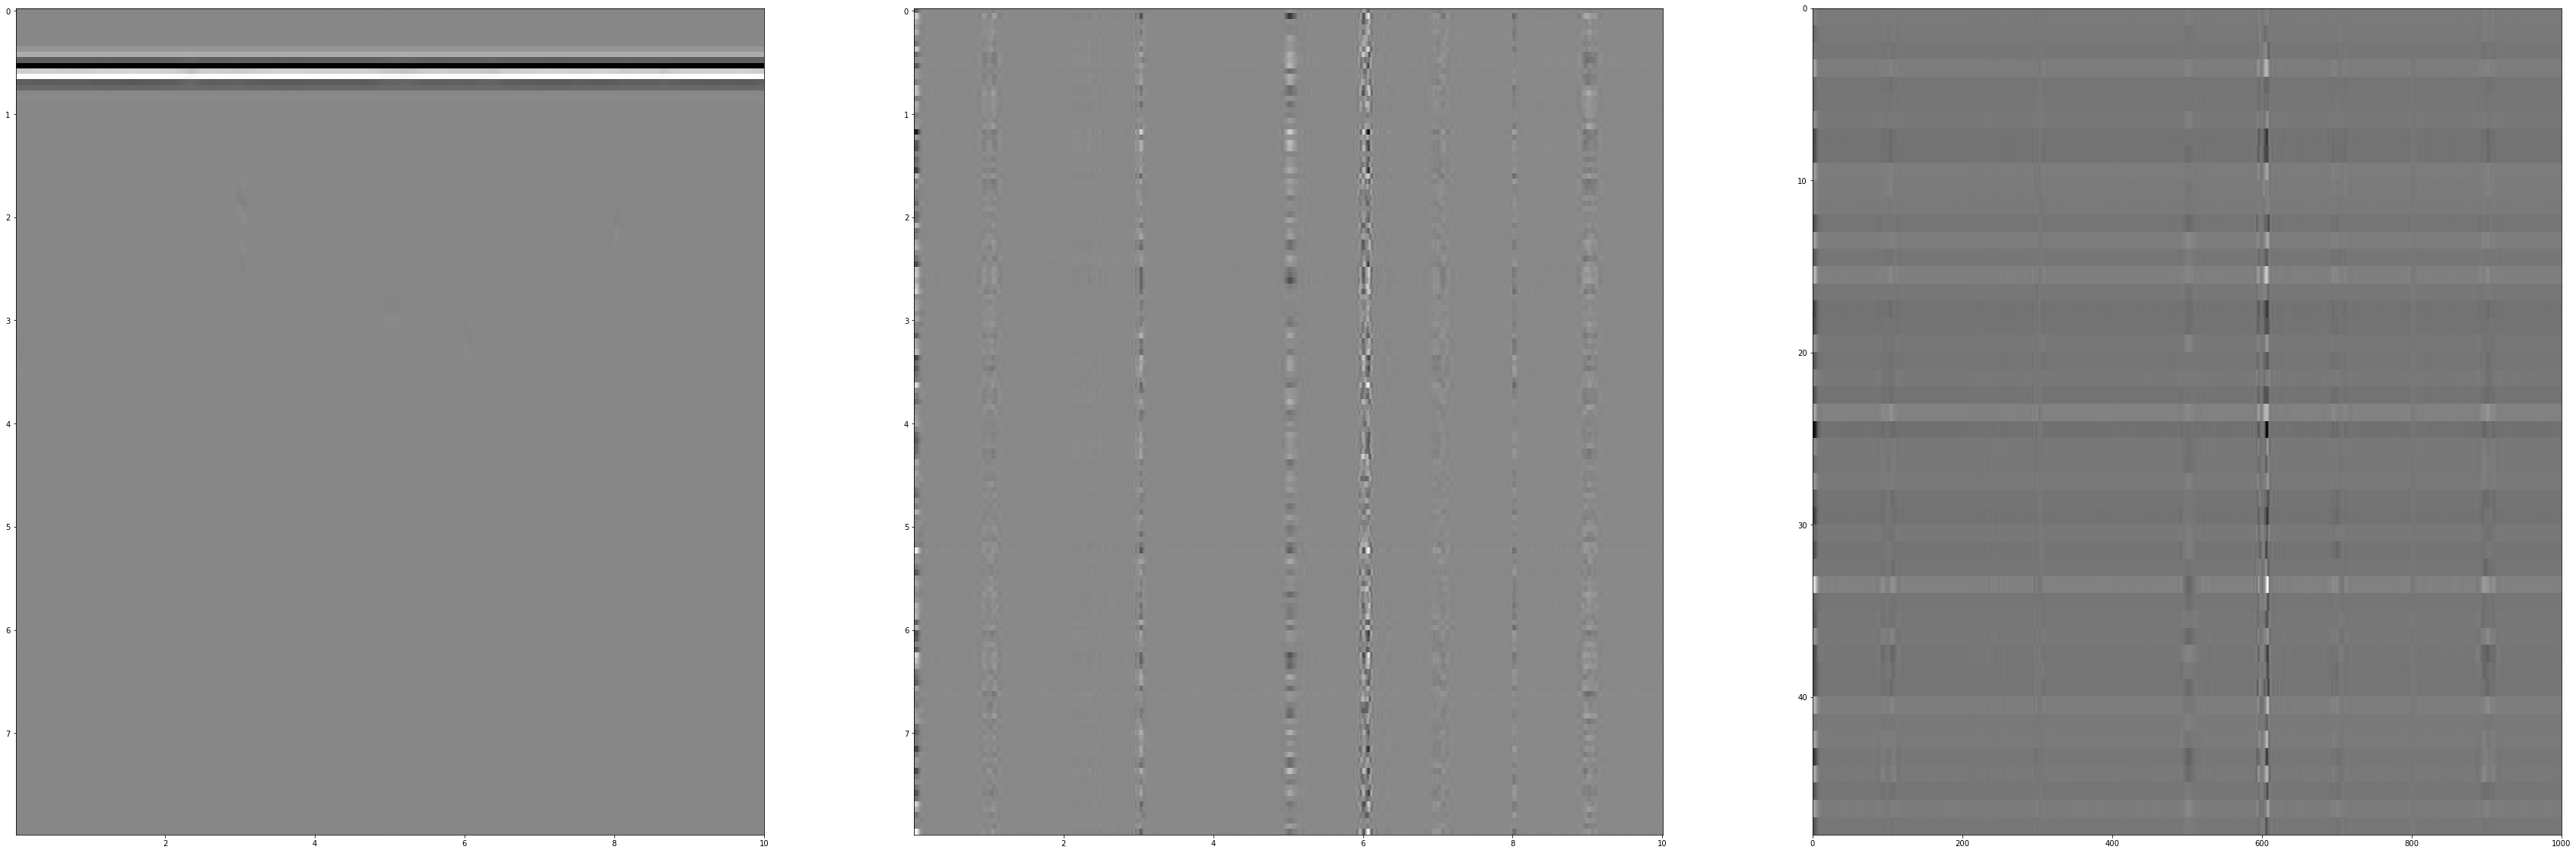

In [33]:
b_scan_t = cls.remove_clutter(X_5*np.exp(1e9*t)[np.newaxis,:])
sp_t = cls.get_coding(X_5*np.exp(1e9*t)[np.newaxis,:])
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (60, 20))
ax1.pcolor(x[:], t[:]/10**-9, X_5.swapaxes(0, 1), cmap='gist_gray')
ax1.invert_yaxis()

ax2.pcolor(x[:], t[:]/10**-9, b_scan_t.swapaxes(0, 1), cmap='gist_gray')
ax2.invert_yaxis()

ax3.pcolor(sp_t.swapaxes(0, 1), cmap='gist_gray')
ax3.invert_yaxis()

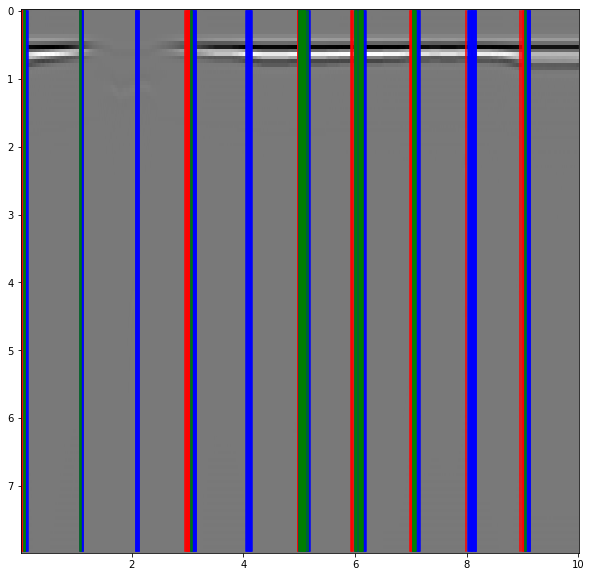

In [36]:
y_pred = cls.predict(X_5*np.exp(1e9*t)[np.newaxis,:])
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.pcolor(x[:], t[:]/10**-9, X_4.swapaxes(0, 1), cmap='gist_gray')
ax.invert_yaxis()
for idx in np.nonzero(y_pred ==True)[0]:
    ax.plot(np.repeat(x[idx], t.size), t*1e9, "r")
for idx in np.nonzero(y_5 ==True)[0]:
    ax.plot(np.repeat(x[idx], t.size), t*1e9, "b")
for idx in np.nonzero((y_5 ==True) & (y_pred ==True) )[0]:
    ax.plot(np.repeat(x[idx], t.size), t*1e9, "g")